In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

model_path = './car_sale_model_12mons_n256_e100_b50_lr0.15.keras'

In [2]:
# load models
model = keras.models.load_model(model_path)

In [3]:
# import pandas
import pandas as pd
# load data from Stat Canada for all post-war era (1946 to 2021)
path_CSdata = 'https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData.action?pid=2010000101&latestN=0&startDate=19460101&endDate=20210701&csvLocale=en&selectedMembers=%5B%5B%5D%2C%5B%5D%2C%5B%5D%2C%5B%5D%2C%5B1%5D%5D&checkedLevels=0D1%2C1D1%2C1D2%2C2D1%2C3D1'
CS_df_full = pd.read_csv(path_CSdata)

# normalize the dataset
def normalize_ts(ts_input):
    min_ts = np.min(ts_input)
    max_ts = np.max(ts_input)
    diff_min_max = max_ts - min_ts
    ts_scaled = (ts_input - min_ts)/(max_ts - min_ts)
    return ts_scaled, diff_min_max, min_ts

def rescale_ts(normalized_ts,diff_min_max,min_units):
    ts_rescl = normalized_ts * diff_min_max + min_units
    return ts_rescl


In [4]:
# load dictionary from dataset
import pickle
# Load data (deserialize)
with open('CA_carsales_total.pickle', 'rb') as handle:
    data_dict = pickle.load(handle)

month_cs = data_dict['month_cs'];
units_cs_total_scl = data_dict['units_cs_total_scl']
diff_min_max_cs_total =  data_dict['diff_min_max_cs_total']
min_cs_total=  data_dict['min_cs_total']


In [5]:
# Based on dataset
start_year =1946; start_year_str = '{:04d}'.format(start_year);
end_year = 2021;
min_month = 1;
max_month = 12;
end_month = 8;
# simplified linspace
def linspace(start, stop, step=1.):
    return np.linspace(start, stop, int((stop - start) / step + 1))

years = linspace(start_year,end_year,step=1).astype(int)
months = linspace(min_month, max_month).astype(int)
print(years)
print(months)

month_str_arr = ['']*((end_year-start_year)*12 + end_month -1)

# find the corresponding index
def find_monarr_ind(year_in,month_in):
    if (year_in >end_year or year_in<start_year) and (month_in>max_month or month_in<min_month):
        print('ERRORS IN INPUT')
        if year_in ==2021 and month_in>end_month:
            print('ERRORS IN INPUT')
    else:
        years_ind= np.where(years ==year_in)[0]+1
        print(years_ind)    
        month_ind= np.where(months == month_in)[0]+1
        print(month_ind)
        if years_ind[0]>0:
            monarr_ind = (12 * (years_ind-1)) + (month_ind)-1
        else:
            monarr_ind = month_ind
    return monarr_ind.squeeze()

[1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959
 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [6]:
# get the (year, month) for the starting point of the prediction
def year_mon_plus_back(test_year, test_month, mon_plus, mon_back):
    # e.g., test set starting at 2008/01 with 12-months look_backwards
    # known info is from 2007/01 to 2007/12
    # prediction will be given for 2008/01 to 2008/06
    old_year_start = test_year - 1 
    old_mon_start = test_month
    old_mon_end = test_month -1
    old_year_end = test_year
    if old_mon_end ==0:
        old_mon_end = 12
        old_year_end = test_year -1
    new_year_end = test_year
    new_mon_end = test_month + 6 - 1
    if new_mon_end>12:
        new_mon_end = new_mon_end - 12
        new_year_end + 1
    return old_year_start,old_mon_start,old_year_end,old_mon_end,new_year_end, new_mon_end

year_mon_plus_back(2017,7,6,12)


(2016, 7, 2017, 6, 2017, 12)

In [7]:
def get_model_input(test_year, test_month):
#     if test_year > 2016 or (test_month>8 and test_year >= 2020):
#         print('Please type anything between 2007-01 to 2020-08')
    look_back = 12;
    look_forward = 6;
    old_year_start,old_mon_start,old_year_end,old_mon_end,new_year_end, new_mon_end = year_mon_plus_back(test_year,test_month,look_back,look_back)
    # Training month index
    mon_index_train = find_monarr_ind(old_year_start,old_mon_start)
    input_cs = units_cs_total_scl[mon_index_train-look_back:mon_index_train]
    cs_train = rescale_ts(input_cs,diff_min_max_cs_total,min_cs_total)
    
    # Testing month index
    mon_index_train = find_monarr_ind(test_year,test_month)
    cs_test = rescale_ts(units_cs_total_scl[mon_index_train:mon_index_train+look_forward],diff_min_max_cs_total,min_cs_total)

    # prediction
    input_cs_rsp = input_cs.reshape(1,look_back,1)
    pred_cs = rescale_ts(model.predict(input_cs_rsp),diff_min_max_cs_total,min_cs_total)

    error = np.mean(pred_cs-cs_test)
    pct_error = np.mean(pred_cs-cs_test)/np.mean(cs_test)
    print('=== Training (input) data for Car sales (x1000 units) in canada from '+ str(old_year_start)+'/' + str(old_mon_start)
          +' to '+ str(old_year_end)+'/' + str(old_mon_end))
    print( '===>' + str(cs_train/1000))
    print('=== Test (true value) Car sales (x1000 units) in canada from '+ str(test_year)+'/' + str(test_month)
          +' to '+ str(new_year_end)+'/' + str(new_mon_end))
    print( '===>' + str(cs_test/1000))
    print('=== Test (prediction) Car sales (x1000 units) in canada from '+ str(test_year)+'/' + str(test_month)
      +' to '+ str(new_year_end)+'/' + str(new_mon_end))
    print(pred_cs/1000)
    print('*** Error is '+'{:0.3f}'.format(error/1000)+' (x1000) vehicle (of '+'{:0.3f}'.format(np.mean(cs_test/1000))+'(x1000) nationalwide)', end='')
    print(', which is '+'{:0.3f}'.format(pct_error*100)+' (%) of the average sale of the testing period (6-month).')
    return input_cs,cs_test,pred_cs,error,pct_error
    


input_cs,cs_test,pred_cs,error,pct_error = get_model_input(2013, 12)


[67]
[12]
[68]
[12]
=== Training (input) data for Car sales (x1000 units) in canada from 2012/12 to 2013/11
===>[117.863 100.448 109.817 161.688 161.372 180.368 173.19  151.451 152.577
 146.27  138.892 128.849]
=== Test (true value) Car sales (x1000 units) in canada from 2013/12 to 2013/5
===>[115.368  97.624 107.501 160.655 182.239 199.568]
=== Test (prediction) Car sales (x1000 units) in canada from 2013/12 to 2013/5
[[116.3793481  102.79494171 106.18820608 144.26359694 169.78355539
  176.46348502]]
*** Error is -7.847 (x1000) vehicle (of 143.826(x1000) nationalwide), which is -5.456 (%) of the average sale of the testing period (6-month).


In [8]:
# Bias evaluation
test_year = linspace(2007, 2015, step=1)
test_month = linspace(1,12,step=1)
error_arr = np.zeros(len(test_year)*len(test_month))
icount = 0
error_sum = 0
pct_error_sum = 0
for i in range(len(test_year)):
    for j in range(len(test_month)):
        input_cs,cs_test,pred_cs,error,pct_error=get_model_input(test_year[i],test_month[j])
        error_arr[icount] = error
        error_sum += error
        pct_error_sum += pct_error
        icount+=1
error_mean = error_sum/icount
pct_error_mean = pct_error_sum/icount

[61]
[1]
[62]
[1]
=== Training (input) data for Car sales (x1000 units) in canada from 2006.0/1.0 to 2006.0/12
===>[ 82.019 106.064 148.296 167.441 161.865 166.024 158.796 146.862 128.431
 118.993 124.111 121.408]
=== Test (true value) Car sales (x1000 units) in canada from 2007.0/1.0 to 2007.0/6.0
===>[ 94.413  99.877 154.45  172.428 189.076 172.487]
=== Test (prediction) Car sales (x1000 units) in canada from 2007.0/1.0 to 2007.0/6.0
[[ 87.53020825 106.22258429 138.3100103  157.97447929 175.49811302
  173.95405082]]
*** Error is -7.207 (x1000) vehicle (of 147.122(x1000) nationalwide), which is -4.899 (%) of the average sale of the testing period (6-month).
[61]
[2]
[62]
[2]
=== Training (input) data for Car sales (x1000 units) in canada from 2006.0/2.0 to 2007.0/1.0
===>[106.064 148.296 167.441 161.865 166.024 158.796 146.862 128.431 118.993
 124.111 121.408  89.422]
=== Test (true value) Car sales (x1000 units) in canada from 2007.0/2.0 to 2007.0/7.0
===>[ 99.877 154.45  172.428 189

===>[105.546 113.877 153.505 179.289 188.137 163.064]
=== Test (prediction) Car sales (x1000 units) in canada from 2008.0/1.0 to 2008.0/6.0
[[ 95.1236533  110.12925991 140.10231844 161.61990907 176.09424908
  171.86123717]]
*** Error is -8.081 (x1000) vehicle (of 150.570(x1000) nationalwide), which is -5.367 (%) of the average sale of the testing period (6-month).
[62]
[2]
[63]
[2]
=== Training (input) data for Car sales (x1000 units) in canada from 2007.0/2.0 to 2008.0/1.0
===>[100.74  155.99  159.436 173.291 162.029 145.521 157.868 140.065 123.076
 127.732 131.157  94.413]
=== Test (true value) Car sales (x1000 units) in canada from 2008.0/2.0 to 2008.0/7.0
===>[113.877 153.505 179.289 188.137 163.064 152.704]
=== Test (prediction) Car sales (x1000 units) in canada from 2008.0/2.0 to 2008.0/7.0
[[ 97.22498188 132.71562367 152.04654143 161.92257256 168.89653374
  155.6085249 ]]
*** Error is -13.694 (x1000) vehicle (of 158.429(x1000) nationalwide), which is -8.643 (%) of the average sa

=== Training (input) data for Car sales (x1000 units) in canada from 2008.0/4.0 to 2009.0/3.0
===>[172.428 189.076 172.487 145.37  160.883 134.516 124.072 120.012 122.954
 105.546 113.877 153.505]
=== Test (true value) Car sales (x1000 units) in canada from 2009.0/4.0 to 2009.0/9.0
===>[146.026 156.025 140.442 141.621 136.971 131.275]
=== Test (prediction) Car sales (x1000 units) in canada from 2009.0/4.0 to 2009.0/9.0
[[157.35157645 178.38128112 162.38340574 153.80598584 154.1726478
  140.39399702]]
*** Error is 15.688 (x1000) vehicle (of 142.060(x1000) nationalwide), which is 11.043 (%) of the average sale of the testing period (6-month).
[63]
[5]
[64]
[5]
=== Training (input) data for Car sales (x1000 units) in canada from 2008.0/5.0 to 2009.0/4.0
===>[189.076 172.487 145.37  160.883 134.516 124.072 120.012 122.954 105.546
 113.877 153.505 179.289]
=== Test (true value) Car sales (x1000 units) in canada from 2009.0/5.0 to 2009.0/10.0
===>[156.025 140.442 141.621 136.971 131.275 123.

=== Training (input) data for Car sales (x1000 units) in canada from 2009.0/5.0 to 2010.0/4.0
===>[188.137 163.064 152.704 149.607 137.479 126.064 107.709  97.164  78.817
  82.039 129.831 146.026]
=== Test (true value) Car sales (x1000 units) in canada from 2010.0/5.0 to 2010.0/10.0
===>[157.082 156.891 150.8   138.21  137.349 125.731]
=== Test (prediction) Car sales (x1000 units) in canada from 2010.0/5.0 to 2010.0/10.0
[[159.60540677 168.11904919 142.70754884 134.71801007 138.6959771
  131.90866836]]
*** Error is 1.615 (x1000) vehicle (of 144.344(x1000) nationalwide), which is 1.119 (%) of the average sale of the testing period (6-month).
[64]
[6]
[65]
[6]
=== Training (input) data for Car sales (x1000 units) in canada from 2009.0/6.0 to 2010.0/5.0
===>[163.064 152.704 149.607 137.479 126.064 107.709  97.164  78.817  82.039
 129.831 146.026 156.025]
=== Test (true value) Car sales (x1000 units) in canada from 2010.0/6.0 to 2010.0/11.0
===>[156.891 150.8   138.21  137.349 125.731 118.

=== Training (input) data for Car sales (x1000 units) in canada from 2010.0/7.0 to 2011.0/6.0
===>[141.621 136.971 131.275 123.607 104.589 113.613  83.512 101.788 148.052
 152.187 157.082 156.891]
=== Test (true value) Car sales (x1000 units) in canada from 2011.0/7.0 to 2011.0/12.0
===>[144.171 143.653 137.66  129.049 124.466 117.863]
=== Test (prediction) Car sales (x1000 units) in canada from 2011.0/7.0 to 2011.0/12.0
[[141.66022553 139.61834545 127.10425919 129.42193198 128.29627131
  110.62867027]]
*** Error is -3.355 (x1000) vehicle (of 132.810(x1000) nationalwide), which is -2.526 (%) of the average sale of the testing period (6-month).
[65]
[8]
[66]
[8]
=== Training (input) data for Car sales (x1000 units) in canada from 2010.0/8.0 to 2011.0/7.0
===>[136.971 131.275 123.607 104.589 113.613  83.512 101.788 148.052 152.187
 157.082 156.891 150.8  ]
=== Test (true value) Car sales (x1000 units) in canada from 2011.0/8.0 to 2011.0/1.0
===>[143.653 137.66  129.049 124.466 117.863 10

=== Test (true value) Car sales (x1000 units) in canada from 2012.0/9.0 to 2012.0/2.0
===>[146.27  138.892 128.849 111.881  97.872 105.811]
=== Test (prediction) Car sales (x1000 units) in canada from 2012.0/9.0 to 2012.0/2.0
[[137.88089686 142.58131989 125.74301447 108.04701517 108.96545106
  121.39613651]]
*** Error is 2.506 (x1000) vehicle (of 121.596(x1000) nationalwide), which is 2.061 (%) of the average sale of the testing period (6-month).
[66]
[10]
[67]
[10]
=== Training (input) data for Car sales (x1000 units) in canada from 2011.0/10.0 to 2012.0/9.0
===>[125.731 118.521 114.376  86.32   98.147 156.452 162.613 152.064 168.119
 144.171 143.653 137.66 ]
=== Test (true value) Car sales (x1000 units) in canada from 2012.0/10.0 to 2012.0/3.0
===>[138.892 128.849 111.881  97.872 105.811 159.953]
=== Test (prediction) Car sales (x1000 units) in canada from 2012.0/10.0 to 2012.0/3.0
[[132.74404144 135.79614314 108.33164131  92.39966238 116.49654213
  149.33774088]]
*** Error is -1.359

=== Training (input) data for Car sales (x1000 units) in canada from 2012.0/11.0 to 2013.0/10.0
===>[124.466 117.863 100.448 109.817 161.688 161.372 180.368 173.19  151.451
 152.577 146.27  138.892]
=== Test (true value) Car sales (x1000 units) in canada from 2013.0/11.0 to 2013.0/4.0
===>[135.776 115.368  97.624 107.501 160.655 182.239]
=== Test (prediction) Car sales (x1000 units) in canada from 2013.0/11.0 to 2013.0/4.0
[[135.23700477 118.76400933  98.22685108 116.631988   154.02359104
  176.79454027]]
*** Error is 0.086 (x1000) vehicle (of 133.194(x1000) nationalwide), which is 0.064 (%) of the average sale of the testing period (6-month).
[67]
[12]
[68]
[12]
=== Training (input) data for Car sales (x1000 units) in canada from 2012.0/12.0 to 2013.0/11.0
===>[117.863 100.448 109.817 161.688 161.372 180.368 173.19  151.451 152.577
 146.27  138.892 128.849]
=== Test (true value) Car sales (x1000 units) in canada from 2013.0/12.0 to 2013.0/5.0
===>[115.368  97.624 107.501 160.655 182.2

=== Training (input) data for Car sales (x1000 units) in canada from 2013.0/12.0 to 2014.0/11.0
===>[111.881  97.872 105.811 159.953 175.181 189.03  174.439 161.835 161.371
 151.644 148.181 135.776]
=== Test (true value) Car sales (x1000 units) in canada from 2014.0/12.0 to 2014.0/5.0
===>[134.829 101.597 111.933 164.402 192.647 201.603]
=== Test (prediction) Car sales (x1000 units) in canada from 2014.0/12.0 to 2014.0/5.0
[[115.03280626  96.55587743 103.18333949 146.35296562 176.38733165
  185.82443442]]
*** Error is -13.946 (x1000) vehicle (of 151.168(x1000) nationalwide), which is -9.225 (%) of the average sale of the testing period (6-month).
[69]
[1]
[70]
[1]
=== Training (input) data for Car sales (x1000 units) in canada from 2014.0/1.0 to 2014.0/12
===>[ 97.872 105.811 159.953 175.181 189.03  174.439 161.835 161.371 151.644
 148.181 135.776 115.368]
=== Test (true value) Car sales (x1000 units) in canada from 2015.0/1.0 to 2015.0/6.0
===>[101.597 111.933 164.402 192.647 201.603 

Mean error from 2007/01 to 2020/12 is -4806.152728598795


Text(0.5, 1.0, 'Mean error for each prediction')

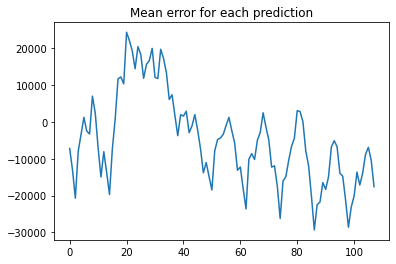

In [9]:
print('Mean error from 2007/01 to 2020/12 is '+str(error_mean))
plt.plot(error_arr)
plt.title('Mean error for each prediction')